## Others: Hindsight Experience Replay (HER) in Goal Oriented Reinforcement Learning (GoRL)

目标导向强化学习： 事后观察经验回放

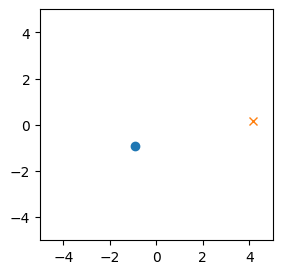

In [3]:
import random
import numpy as np

# 定义环境
class MyWrapper:
  
  def reset(self):
    # 前两个数是起点,后两个数是终点
    self.state = np.random.uniform(size=4, low=-5, high=5)
    self.step_n = 0
    return self.state.tolist()
  
  def step(self, action):
    action = np.array(action).reshape(2)
    
    # 裁剪动作范围
    action = action.clip(min=-1, max=1)
    
    # 执行动作
    self.state[:2] += action
    
    # 规范状态空间
    self.state[:2] = self.state[:2].clip(min=-5, max=5)
    
    # 求距离终点的距离
    dist = np.linalg.norm(self.state[:2] - self.state[2:], ord=2)
    
    # 判断到达终点
    reward = -1.0
    over = False
    if dist < 0.1:
      reward = 1.0
      over = True
      
    # 限制最大步数
    self.step_n += 1
    if self.step_n >= 50:
      over = True
      
    return self.state.tolist(), reward, over
  
  
  def show(self):
    from matplotlib import pyplot as plt
    plt.figure(figsize=(3, 3))
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    
    plt.plot(*self.state[:2], 'o')
    plt.plot(*self.state[2:], 'x')
    plt.show()
    
env = MyWrapper()
env.reset()
env.show()

In [4]:
from ddpg import DDPG 
import torch

ddpg = DDPG()

ddpg

In [5]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
  data = []
  reward_sum = 0

  state = env.reset()
  over = False
  while not over:
    # 根据环境采样
    action = ddpg.model_action(torch.FloatTensor(state).reshape(1, 4)).reshape(2)

    # 给动作添加噪声，增加探索
    action += torch.randn(2) * 0.1
    action = action.tolist()
    
    next_state, reward, over = env.step(action)

    data.append((state, action, reward, next_state, over))
    reward_sum += reward
    
    state = next_state

    if show:
      display.clear_output(wait=True)
      env.show()

  return data, reward_sum

play()[-1]

-50.0

In [6]:
# 从一局游戏中取一条伪终点的数据
def get_fake_goal_data(data_game, step):
  # 取出step的数据
  state, action, reward, next_state, over = data_game[step]
  
  # 随机step后面的某一步数据
  step = random.randint(step + 1, len(data_game) - 1)
  fake_goal_state = data_game[step][0]
  
  # 以伪终点构建新的state
  state[2:] = fake_goal_state[:2]
  next_state[2:] = fake_goal_state[:2]
  
  # 求距离终点的距离
  dist = [next_state[0] - next_state[2], next_state[1] - next_state[3]]
  dist = np.linalg.norm(dist, ord=2)
  
  # 重新计算reward和over
  reward = -1.0
  over = False
  if dist < 0.1:
    reward = 1.0
    over = True
  
  # 返回作为伪终点的数据
  return state, action, reward, next_state, over

get_fake_goal_data(play()[0], 0)

([-2.4308068218595382, -4.657759560990988, 5.0, 3.994603575419725],
 [0.5086904168128967, 0.11522974818944931],
 -1.0,
 [-1.9221164050466415, -4.542529812801539, 5.0, 3.994603575419725],
 False)

In [7]:
class Pool:
  
  def __init__(self):
    self.pool = []
    
  def __len__(self):
    return sum(len(i) for i in self.pool)
  
  def __getitem__(self, i):
    return self.pool[i]
  
  # 更新动作
  def update(self):
    # 每次更新至少N条数据
    old_len = len(self)
    while len(self) - old_len < 200:
      self.pool.append(play()[0])
      
    # 保留最新N条数据
    while len(self) > 2_0000:
      self.pool = self.pool[1:]
      

  # 获取一批数据样本
  def sample(self):
    data = []
    for _ in range(64):
      # 随机一局游戏
      data_game = random.choice(self.pool)
      
      # 随机取游戏中的一步数据
      step = random.randint(0, len(data_game) - 1)
      data_step = data_game[step]
      
      # 随机替换为伪终点数据
      if step < len(data_game) - 1 and random.random() < 0.8:
        data_step = get_fake_goal_data(data_game, step)
        
      data.append(data_step)
    
    state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 4)
    action = torch.FloatTensor([i[1] for i in data]).reshape(-1, 2)
    reward = torch.FloatTensor([i[2] for i in data]).reshape(-1, 1)
    next_state = torch.FloatTensor([i[3] for i in data]).reshape(-1, 4)
    over = torch.LongTensor([i[4] for i in data]).reshape(-1, 1)
    
    return state, action, reward, next_state, over

pool = Pool()
pool.update()
pool.sample()

len(pool), pool[0][0]

(200,
 ([-4.537123834744524,
   4.439853111305558,
   0.6322902699825148,
   1.9848531264588098],
  [0.024813681840896606, 0.24908727407455444],
  -1.0,
  [-4.512310152903628,
   4.688940385380112,
   0.6322902699825148,
   1.9848531264588098],
  False))

In [8]:
#训练
def train():
	# 共更新N轮数据
  for epoch in range(1000):
    pool.update()
    
    # 每次更新过数据后,学习N次
    for i in range(200):
      # 采样一批
      state, action, reward, next_state, over = pool.sample()

      # 训练
      ddpg.train_action(state)
      ddpg.train_value(state, action, reward, next_state, over)
      ddpg.soft_update()

    if epoch % 100 == 0:
      test_result = sum([play()[-1] for _ in range(20)]) / 20
      print(epoch, len(pool), test_result)
      
train()

0 400 -50.0
100 19962 -50.0
200 19979 -33.1
300 19994 -13.0
400 19985 -5.2
500 19999 -5.8
600 19993 -4.25
700 19999 -4.95
800 19995 -4.95
900 19993 -4.95


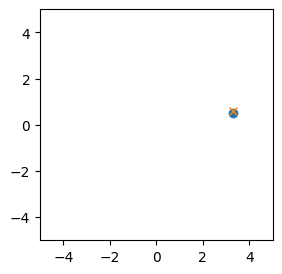

-6.0

In [10]:
play(True)[-1]